In [ ]:
#3) Ingesta desde API pública (Binance) → guardado a CSV

In [ ]:
# =========================
# Dependencias y carpetas
# =========================
import os, time, requests
import pandas as pd
from pathlib import Path

DATA_RAW = Path("data/raw")
DATA_RAW.mkdir(parents=True, exist_ok=True)

# =========================
# Funciones API Binance
# =========================
BIN = "https://api.binance.com/api/v3/klines"

def _to_ms(dt_str: str) -> int:
    return int(pd.Timestamp(dt_str, tz="UTC").timestamp() * 1000)

def get_klines(symbol="BTCUSDT", interval="1d", start="2017-01-01", end=None, limit=1000, sleep=0.25):
    
    if end is None:
        end = pd.Timestamp.utcnow().strftime("%Y-%m-%d")
    start_ms, end_ms = _to_ms(start), _to_ms(end)
    out, cur = [], start_ms
    while True:
        params = {"symbol": symbol, "interval": interval, "limit": limit, "startTime": cur, "endTime": end_ms}
        r = requests.get(BIN, params=params, timeout=30)
        if r.status_code in (418, 429):  # rate limit
            time.sleep(2); continue
        r.raise_for_status()
        chunk = r.json()
        if not chunk:
            break
        out.extend(chunk)
        last_open = chunk[-1][0]
        cur = last_open + 1
        if cur >= end_ms: break
        time.sleep(sleep)
    cols = ["open_time","open","high","low","close","volume","close_time","qav","trades","tb_base","tb_quote","ignore"]
    df = pd.DataFrame(out, columns=cols)
    df[["open","high","low","close","volume"]] = df[["open","high","low","close","volume"]].astype(float)
    df["timestamp"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    return df[["timestamp","open","high","low","close","volume"]]

# =========================
# Descarga y persistencia
# =========================
RUN_API = True  

if RUN_API:
    
    btc = get_klines("BTCUSDT", "1d", start="2017-01-01")
    eth = get_klines("ETHUSDT", "1d", start="2017-01-01")

    btc.to_csv(DATA_RAW/"binance_BTCUSDT_1d.csv", index=False)
    eth.to_csv(DATA_RAW/"binance_ETHUSDT_1d.csv", index=False)
    print("Guardado en:", (DATA_RAW/"binance_BTCUSDT_1d.csv").resolve())
    print("Guardado en:", (DATA_RAW/"binance_ETHUSDT_1d.csv").resolve())

Guardado en: /home/romina/Escritorio/FInalProjectBTCvsRTH/data/raw/binance_BTCUSDT_1d.csv
Guardado en: /home/romina/Escritorio/FInalProjectBTCvsRTH/data/raw/binance_ETHUSDT_1d.csv


In [ ]:
#4)Carga desde CSV (trabajo offline)

In [ ]:
import pandas as pd
from pathlib import Path

DATA_RAW = Path("data/raw")

btc = pd.read_csv(DATA_RAW/"binance_BTCUSDT_1d.csv", parse_dates=["timestamp"])
eth = pd.read_csv(DATA_RAW/"binance_ETHUSDT_1d.csv", parse_dates=["timestamp"])

#Normalizamos nombres y preparamos campos básicos
btc = btc.rename(columns={"close":"price"}); btc["symbol"]="BTC"
eth = eth.rename(columns={"close":"price"}); eth["symbol"]="ETH"

#Alineación por fechas comunes (para comparabilidad)
start = max(btc["timestamp"].min(), eth["timestamp"].min())
end   = min(btc["timestamp"].max(), eth["timestamp"].max())
btc = btc[(btc["timestamp"]>=start) & (btc["timestamp"]<=end)].reset_index(drop=True)
eth = eth[(eth["timestamp"]>=start) & (eth["timestamp"]<=end)].reset_index(drop=True)

common_days = sorted(set(btc["timestamp"]).intersection(set(eth["timestamp"])))
btc = btc[btc["timestamp"].isin(common_days)].reset_index(drop=True)
eth = eth[eth["timestamp"].isin(common_days)].reset_index(drop=True)

#Retornos diarios
btc["ret_d"] = btc["price"].pct_change()
eth["ret_d"] = eth["price"].pct_change()


In [ ]:
#5) Resumen de metadata (inicio de EDA)

#Un pantallazo rápido de tamaño, tipos y nulos para documentar el dataset.

In [3]:
import numpy as np

def meta(df, name):
    return pd.DataFrame({
        "rows":[len(df)],
        "cols":[df.shape[1]],
        "fecha_min":[df["timestamp"].min()],
        "fecha_max":[df["timestamp"].max()],
        "nulos_price":[df["price"].isna().sum()],
        "nulos_ret_d":[df["ret_d"].isna().sum()]
    }, index=[name])

meta_df = pd.concat([meta(btc,"BTC"), meta(eth,"ETH")])
display(meta_df)

print("\nTipos BTC:\n", btc.dtypes)
print("\nTipos ETH:\n", eth.dtypes)


,rows,cols,fecha_min,fecha_max,nulos_price,nulos_ret_d
BTC,2959,8,2017-08-17 00:00:00+00:00,2025-09-22 00:00:00+00:00,0,1
ETH,2959,8,2017-08-17 00:00:00+00:00,2025-09-22 00:00:00+00:00,0,1



Tipos BTC:
 timestamp    datetime64[ns, UTC]
open                     float64
high                     float64
low                      float64
price                    float64
volume                   float64
symbol                    object
ret_d                    float64
dtype: object

Tipos ETH:
 timestamp    datetime64[ns, UTC]
open                     float64
high                     float64
low                      float64
price                    float64
volume                   float64
symbol                    object
ret_d                    float64
dtype: object


In [ ]:
#6)Feature engineering: vol, drawdown, momentum, panele
import numpy as np
import pandas as pd

def _add_features(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()
    d["ret_d"]   = d["price"].pct_change()
    d["abs_ret"] = d["ret_d"].abs()
    #volatilidad anualizada rolling
    d["vol_30"] = d["ret_d"].rolling(30, min_periods=15).std() * np.sqrt(365)
    d["vol_90"] = d["ret_d"].rolling(90, min_periods=45).std() * np.sqrt(365)
    #drawdown
    peak = d["price"].cummax()
    d["dd"] = d["price"]/peak - 1.0
    #momentum
    d["mom_30"] = d["price"]/d["price"].shift(30) - 1
    d["mom_90"] = d["price"]/d["price"].shift(90) - 1
    #índice base=100 para gráfico de precio
    base = d["price"].iloc[0]
    d["idx100"] = 100*d["price"]/base
    return d

btc = _add_features(btc)
eth = _add_features(eth)

#Paneles para gráficos y correlaciones
pv_price = pd.DataFrame({
    "timestamp": btc["timestamp"].values,
    "BTC": btc["price"].values,
    "ETH": eth["price"].values
}).set_index("timestamp")

pv_ret = pd.DataFrame({
    "timestamp": btc["timestamp"].values,
    "BTC": btc["ret_d"].values,
    "ETH": eth["ret_d"].values
}).set_index("timestamp").dropna()

#Fortaleza relativa ETH/BTC
pv_price["ETH_BTC"] = pv_price["ETH"]/pv_price["BTC"]

#Spearman  correlación de retornos
rho_s = pv_ret.corr(method="spearman").loc["BTC","ETH"] if len(pv_ret)>5 else np.nan
rho_s


np.float64(0.7774777111036205)

In [ ]:
#Guardado de figuras
from pathlib import Path
import matplotlib.pyplot as plt

FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(fig, name, dpi=180):
    out = FIG_DIR / name
    fig.savefig(out, dpi=dpi, bbox_inches="tight", facecolor="white", transparent=False)
    print(f"✅ guardada: {out.resolve()}")


In [ ]:
#8) Visualizaciones y análisis

In [ ]:
import matplotlib.pyplot as plt


✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/01_precio_normalizado.png


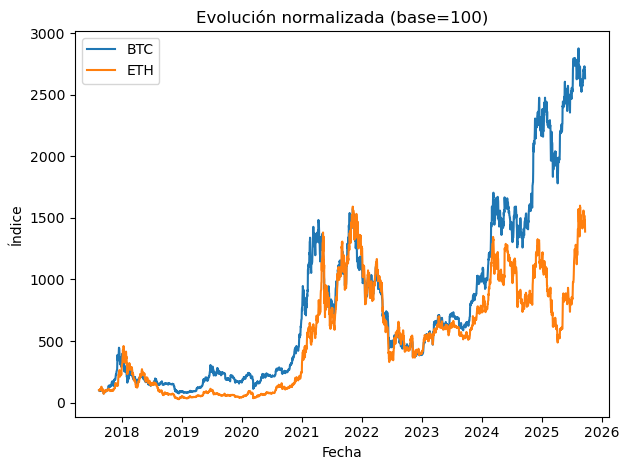

In [ ]:
#1)Precio normalizado (base=100)
fig, ax = plt.subplots()
ax.plot(btc["timestamp"], btc["idx100"], label="BTC")
ax.plot(eth["timestamp"], eth["idx100"], label="ETH")
ax.set_title("Evolución normalizada (base=100)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Índice"); ax.legend(); fig.tight_layout()
savefig(fig, "01_precio_normalizado.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/02_volatilidad_90d.png


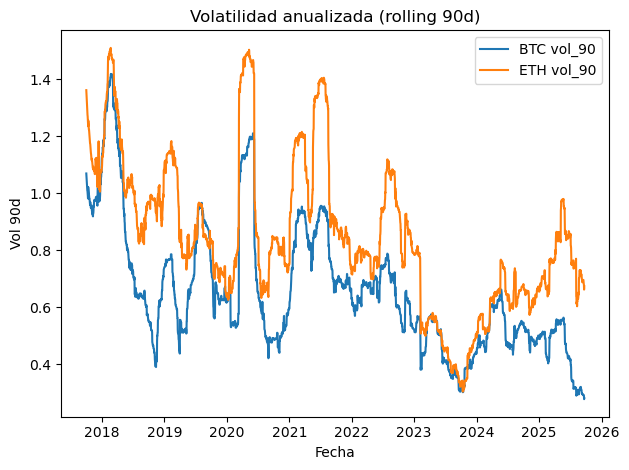

In [ ]:
#2)Volatilidad anualizada (rolling 90d)
fig, ax = plt.subplots()
ax.plot(btc["timestamp"], btc["vol_90"], label="BTC vol_90")
ax.plot(eth["timestamp"], eth["vol_90"], label="ETH vol_90")
ax.set_title("Volatilidad anualizada (rolling 90d)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Vol 90d"); ax.legend(); fig.tight_layout()
savefig(fig, "02_volatilidad_90d.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/03_drawdowns.png


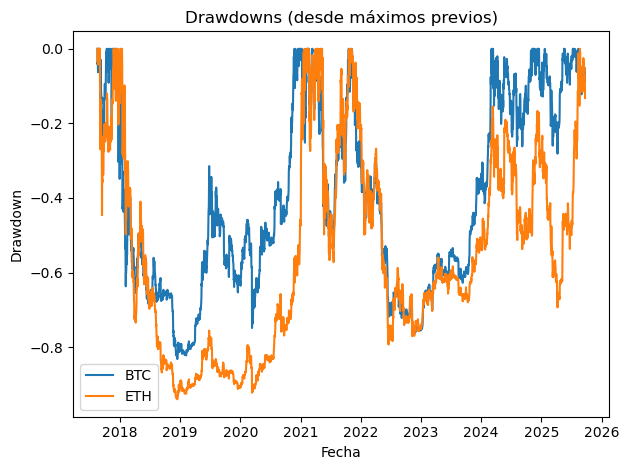

In [ ]:
#3)Drawdowns
fig, ax = plt.subplots()
ax.plot(btc["timestamp"], btc["dd"], label="BTC")
ax.plot(eth["timestamp"], eth["dd"], label="ETH")
ax.set_title("Drawdowns (desde máximos previos)")
ax.set_xlabel("Fecha"); ax.set_ylabel("Drawdown"); ax.legend(); fig.tight_layout()
savefig(fig, "03_drawdowns.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/04_correlacion_spearman.png


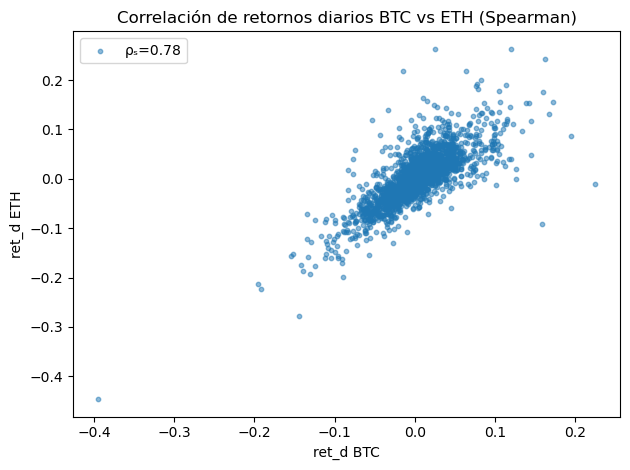

In [ ]:
#4)Correlación de retornos (Sperman)
fig, ax = plt.subplots()
ax.scatter(pv_ret["BTC"], pv_ret["ETH"], s=10, alpha=0.5, label=f"ρₛ={rho_s:.2f}")
ax.set_title("Correlación de retornos diarios BTC vs ETH (Spearman)")
ax.set_xlabel("ret_d BTC"); ax.set_ylabel("ret_d ETH"); ax.legend(); fig.tight_layout()
savefig(fig, "04_correlacion_spearman.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/05_eth_btc.png


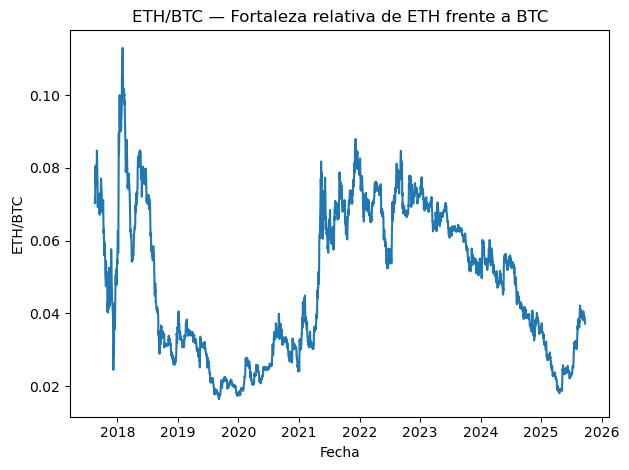

In [ ]:
#5)ETH/BTC — Fortaleza relativa
fig, ax = plt.subplots()
ax.plot(pv_price.index, pv_price["ETH_BTC"])
ax.set_title("ETH/BTC — Fortaleza relativa de ETH frente a BTC")
ax.set_xlabel("Fecha"); ax.set_ylabel("ETH/BTC"); fig.tight_layout()
savefig(fig, "05_eth_btc.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/06_momentum_barras.png


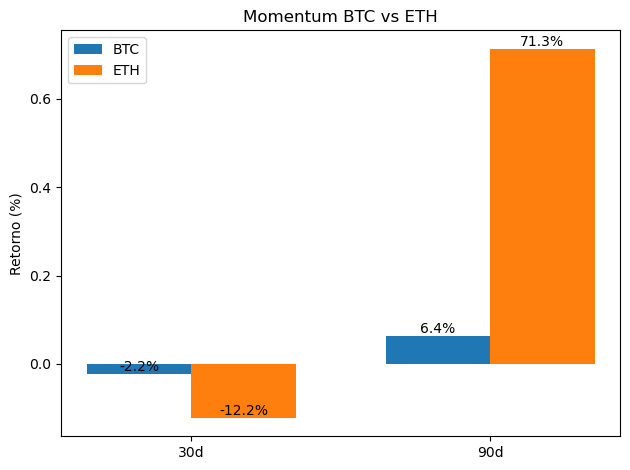

In [ ]:
#6)Momentum 30/90 — barras
def _bar_with_labels(ax, labels, v1, v2, title, ylabel):
    import numpy as np
    x = np.arange(len(labels)); w=0.35
    ax.bar(x-w/2, v1, width=w, label="BTC")
    ax.bar(x+w/2, v2, width=w, label="ETH")
    ax.set_xticks(x); ax.set_xticklabels(labels)
    ax.set_title(title); ax.set_ylabel(ylabel); ax.legend()
    for i, val in enumerate(v1):
        ax.text(i-w/2, val, f"{val*100:.1f}%", ha="center", va="bottom")
    for i, val in enumerate(v2):
        ax.text(i+w/2, val, f"{val*100:.1f}%", ha="center", va="bottom")

mom30_btc = btc["mom_30"].iloc[-1]; mom30_eth = eth["mom_30"].iloc[-1]
mom90_btc = btc["mom_90"].iloc[-1]; mom90_eth = eth["mom_90"].iloc[-1]

fig, ax = plt.subplots()
_bar_with_labels(ax, ["30d","90d"], [mom30_btc, mom90_btc], [mom30_eth, mom90_eth],
                 "Momentum BTC vs ETH", "Retorno (%)")
fig.tight_layout()
savefig(fig, "06_momentum_barras.png")
plt.show()

✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/07_spearman_rolling.png


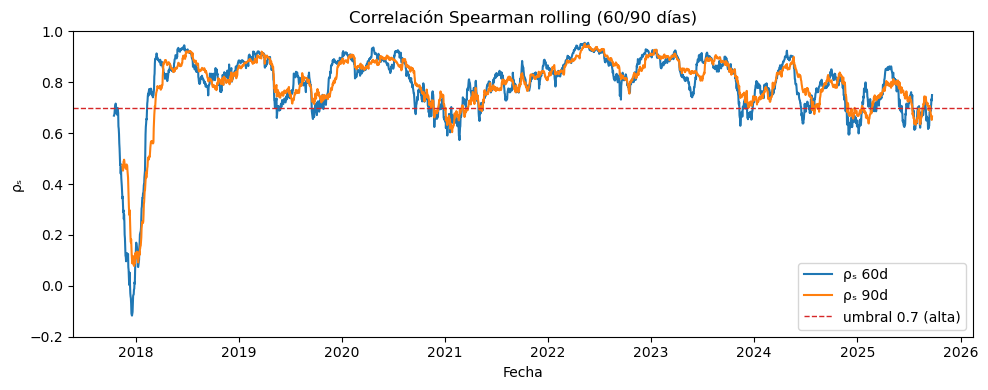

ρₛ total = 0.78 | ρₛ60 último = 0.75 | ρₛ90 último = 0.67
✅ guardada: /home/romina/Escritorio/FInalProjectBTCvsRTH/figures/07_diversificacion_curva_vol.png


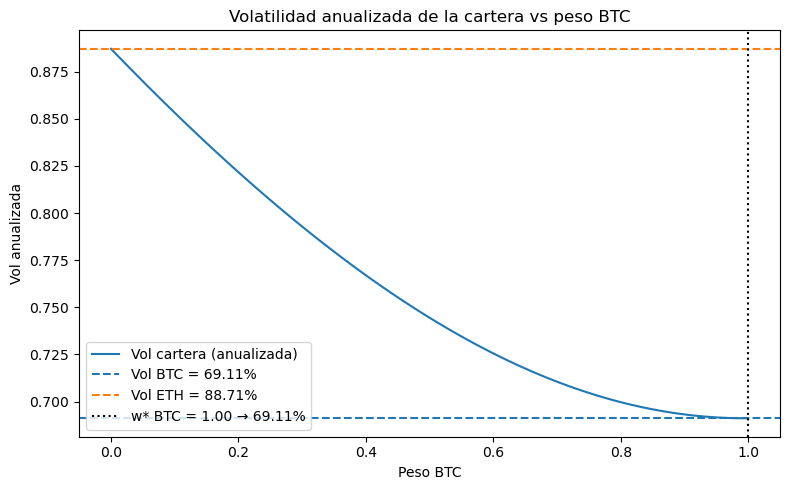

Mín vol cartera = 69.11% con wBTC = 1.00.
Reducción vs activo menos volátil = 0.0% (beneficio de diversificación).


In [ ]:
#7) Diversificación BTC–ETH
#Spearman rolling(60/90 días)
def rolling_spearman(series_x: pd.Series, series_y: pd.Series, win: int) -> pd.Series:
    x = series_x.copy(); y = series_y.copy()
    out = np.full(len(x), np.nan)
    for i in range(win-1, len(x)):
        xs = x.iloc[i-win+1:i+1].rank().values
        ys = y.iloc[i-win+1:i+1].rank().values
        out[i] = np.corrcoef(xs, ys)[0, 1]
    return pd.Series(out, index=series_x.index, name=f"rho_s_{win}")

rho60 = rolling_spearman(pv_ret["BTC"], pv_ret["ETH"], 60)
rho90 = rolling_spearman(pv_ret["BTC"], pv_ret["ETH"], 90)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(rho60.index, rho60, label="ρₛ 60d")
ax.plot(rho90.index, rho90, label="ρₛ 90d")
ax.axhline(0.7, color="tab:red", lw=1, ls="--", label="umbral 0.7 (alta)")
ax.set_ylim(-0.2, 1.0)
ax.set_title("Correlación Spearman rolling (60/90 días)")
ax.set_xlabel("Fecha"); ax.set_ylabel("ρₛ"); ax.legend()
fig.tight_layout()
_save(fig, "07_spearman_rolling.png")
plt.show()

print(f"ρₛ total = {rho_s:.2f} | ρₛ60 último = {rho60.dropna().iloc[-1]:.2f} | ρₛ90 último = {rho90.dropna().iloc[-1]:.2f}")

#2)Cuánto ayuda a diversificar? 
rets = pv_ret.copy()
vol_BTC = rets["BTC"].std() * np.sqrt(365)
vol_ETH = rets["ETH"].std() * np.sqrt(365)

w_grid = np.linspace(0, 1, 101)  # peso BTC
port_vol = []
for w in w_grid:
    rp = w*rets["BTC"] + (1-w)*rets["ETH"]
    port_vol.append(rp.std() * np.sqrt(365))
port_vol = np.array(port_vol)

#Punto de minima volatilidad
i_min = np.argmin(port_vol)
w_star = float(w_grid[i_min])
vol_star = float(port_vol[i_min])

#Beneficio de diversificación: ¿cuánto baja vs el activo menos volátil?
base = min(vol_BTC, vol_ETH)
benefit_pct = (base - vol_star) / base if base > 0 else np.nan

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(w_grid, port_vol, label="Vol cartera (anualizada)")
ax.axhline(vol_BTC, color="tab:blue", ls="--", label=f"Vol BTC = {vol_BTC:.2%}")
ax.axhline(vol_ETH, color="tab:orange", ls="--", label=f"Vol ETH = {vol_ETH:.2%}")
ax.axvline(w_star, color="k", ls=":", label=f"w* BTC = {w_star:.2f} → {vol_star:.2%}")
ax.set_title("Volatilidad anualizada de la cartera vs peso BTC")
ax.set_xlabel("Peso BTC"); ax.set_ylabel("Vol anualizada"); ax.legend()
fig.tight_layout()
_save(fig, "07_diversificacion_curva_vol.png")
plt.show()

print(f"Mín vol cartera = {vol_star:.2%} con wBTC = {w_star:.2f}.")
print(f"Reducción vs activo menos volátil = {benefit_pct:.1%} (beneficio de diversificación).")